## Future Sales Forecast

In [48]:
import matplotlib
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn')
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

#### Load Datasets

In [2]:
items = pd.read_csv('datasets/items.csv')
shops = pd.read_csv('datasets/shops.csv')
sales = pd.read_csv('datasets/sales_train.csv')
items_categories = pd.read_csv('datasets/item_categories.csv')

### Data Processing

In [3]:
# Converting the column 'date' to type 'datetime'.
sales['date'] = sales['date'].apply(lambda d: pd.datetime.strptime(d, '%d.%m.%Y'))

In [4]:
# Create columns 'month' and 'total'.
sales['year'] = sales['date'].apply(lambda d: d.year)
sales['month'] = sales['date'].apply(lambda d: d.month)
sales['total_value'] = sales['item_price'] * sales['item_cnt_day']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
# Adding column 'item_category_id'.
sales = sales.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [6]:
sales.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,year,month,total_value,item_category_id
0,0,2014-09-01,20,54,58.0,1.0,2014,9,58.0,40
1,1,2014-04-04,15,55,4490.0,1.0,2014,4,4490.0,76
2,1,2014-04-02,15,55,4490.0,1.0,2014,4,4490.0,76
3,1,2014-07-06,18,55,4490.0,1.0,2014,7,4490.0,76
4,1,2014-08-04,19,55,4490.0,1.0,2014,8,4490.0,76


### Data Analysis and Exploration

In [7]:
monthly_sales_2013 = sales[sales['year']==2013].groupby(['month'])['item_cnt_day', 'total_value'].sum()
monthly_sales_2014 = sales[sales['year']==2014].groupby(['month'])['item_cnt_day', 'total_value'].sum()
monthly_sales_2015 = sales[sales['year']==2015].groupby(['month'])['item_cnt_day', 'total_value'].sum()

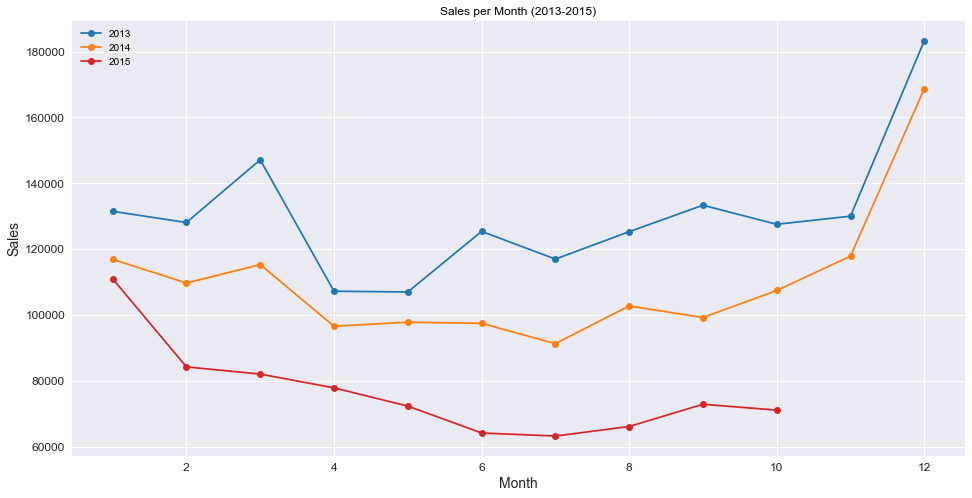

In [8]:
plt.figure(figsize=(16,8))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales per Month (2013-2015)')
plt.plot(monthly_sales_2013['item_cnt_day'], '-ok', color='tab:blue', label='2013')
plt.plot(monthly_sales_2014['item_cnt_day'], '-ok', color='tab:orange', label='2014')
plt.plot(monthly_sales_2015['item_cnt_day'], '-ok', color='tab:red', label='2015')
plt.legend()

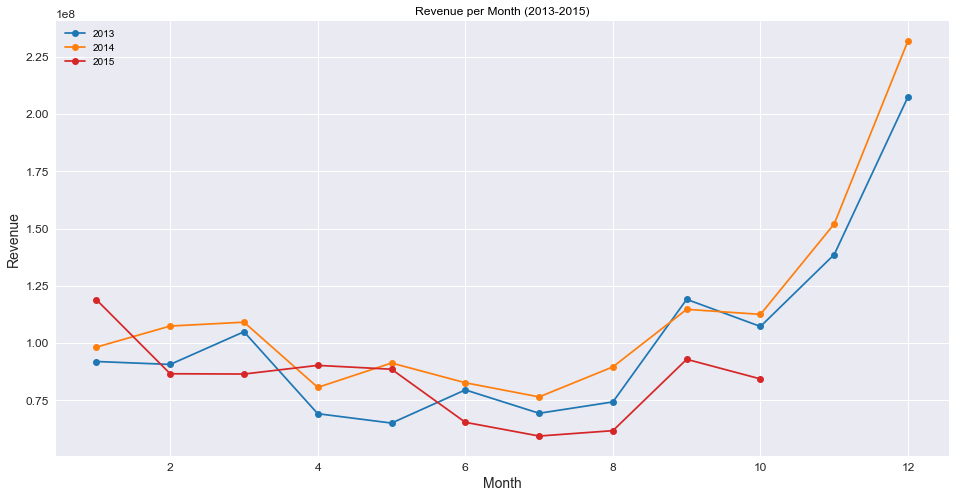

In [9]:
plt.figure(figsize=(16,8))
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Revenue per Month (2013-2015)')
plt.plot(monthly_sales_2013['total_value'], '-ok', color='tab:blue', label='2013')
plt.plot(monthly_sales_2014['total_value'], '-ok', color='tab:orange', label='2014')
plt.plot(monthly_sales_2015['total_value'], '-ok', color='tab:red', label='2015')
plt.legend()

In [10]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day'].sum()

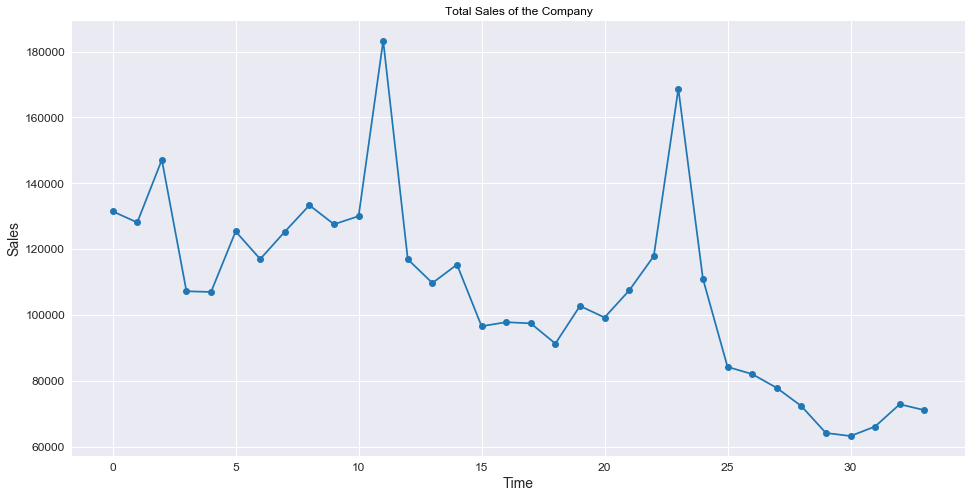

In [11]:
plt.figure(figsize=(16,8))
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Total Sales of the Company')
plt.plot(total_sales, '-ok', color='tab:blue')

In [12]:
decomposition = seasonal_decompose(total_sales.values, freq=12)

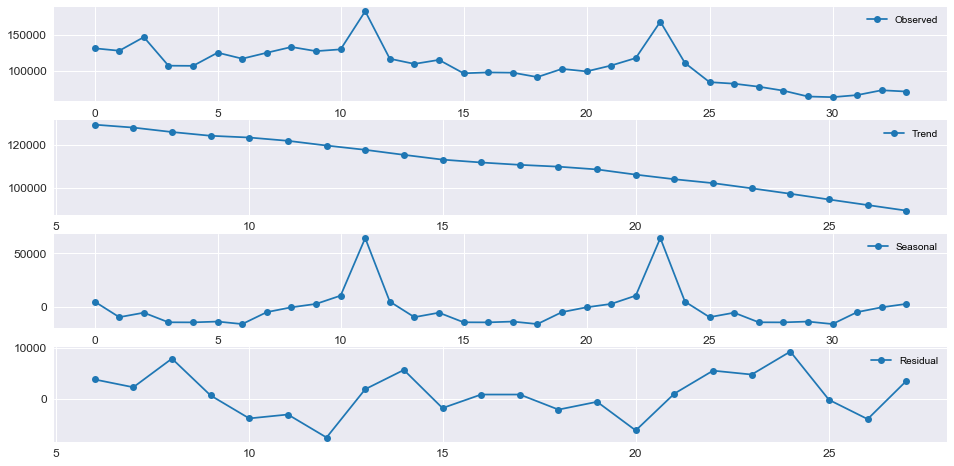

In [13]:
plt.figure(figsize=(16,8))

plt.subplot(4, 1, 1)
plt.plot(total_sales, '-ok', color='tab:blue', label='Observed')
plt.legend(loc='best')

plt.subplot(4, 1, 2) 
plt.plot(decomposition.trend, '-ok', color='tab:blue', label='Trend')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, '-ok', color='tab:blue', label='Seasonal')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, '-ok', color='tab:blue', label='Residual')
plt.legend(loc='best')

In [14]:
stores_sales = sales.groupby(['shop_id'])['item_cnt_day'].agg(item_cnt_day='sum')
stores_sales = stores_sales.sort_values(by='item_cnt_day', ascending=False)

In [15]:
stores_more_sales = stores_sales.iloc[0:10] # TOP 10
stores_more_sales = stores_more_sales.sort_values(by='shop_id').reset_index()

stores_less_sales = stores_sales.iloc[-10:] # LAST 10
stores_less_sales = stores_less_sales.sort_values(by='shop_id').reset_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 10 artists>

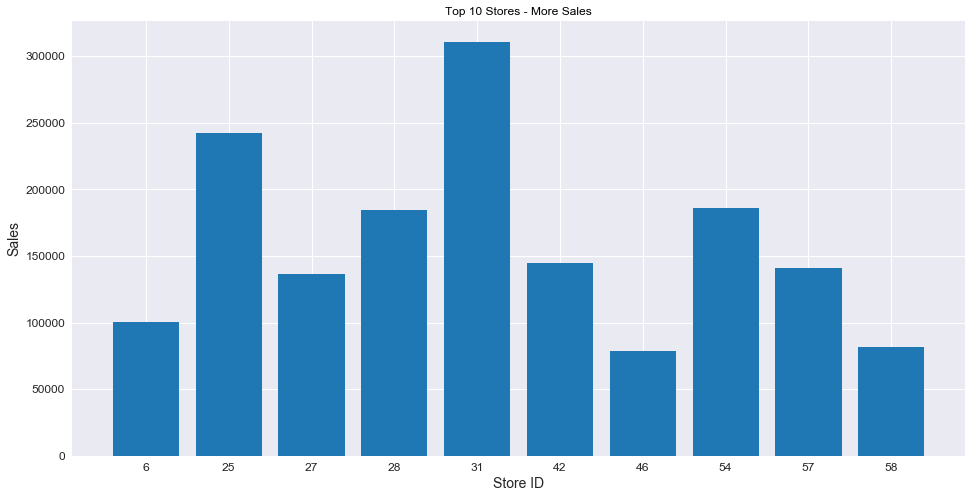

In [16]:
plt.figure(figsize=(16,8))
plt.xlabel('Store ID')
plt.ylabel('Sales')
plt.title('Top 10 Stores - More Sales')
plt.bar(stores_more_sales['shop_id'].astype('str'), stores_more_sales['item_cnt_day'], color='tab:blue')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 10 artists>

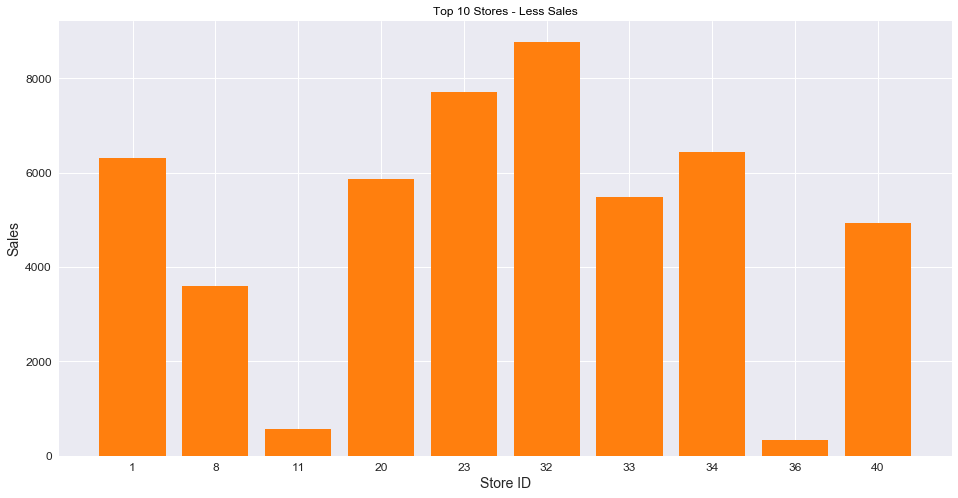

In [17]:
plt.figure(figsize=(16,8))
plt.xlabel('Store ID')
plt.ylabel('Sales')
plt.title('Top 10 Stores - Less Sales')
plt.bar(stores_less_sales['shop_id'].astype('str'), stores_less_sales['item_cnt_day'], color='tab:orange')

In [18]:
stores_revenue = sales.groupby(['shop_id'])['total_value'].agg(total_value='sum')
stores_revenue = stores_revenue.sort_values(by='total_value', ascending=False)

In [19]:
stores_highest_revenue = stores_revenue.iloc[0:10] # TOP 10
stores_highest_revenue = stores_highest_revenue.sort_values(by='shop_id').reset_index()

stores_lower_revenue = stores_revenue.iloc[-10:] # LAST 10
stores_lower_revenue = stores_lower_revenue.sort_values(by='shop_id').reset_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 10 artists>

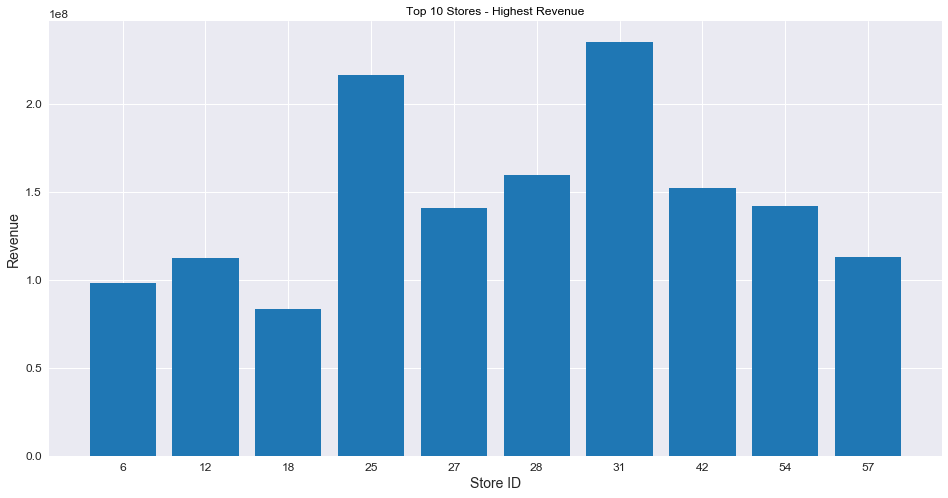

In [20]:
plt.figure(figsize=(16,8))
plt.xlabel('Store ID')
plt.ylabel('Revenue')
plt.title('Top 10 Stores - Highest Revenue')
plt.bar(stores_highest_revenue['shop_id'].astype('str'), stores_highest_revenue['total_value'], color='tab:blue')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 10 artists>

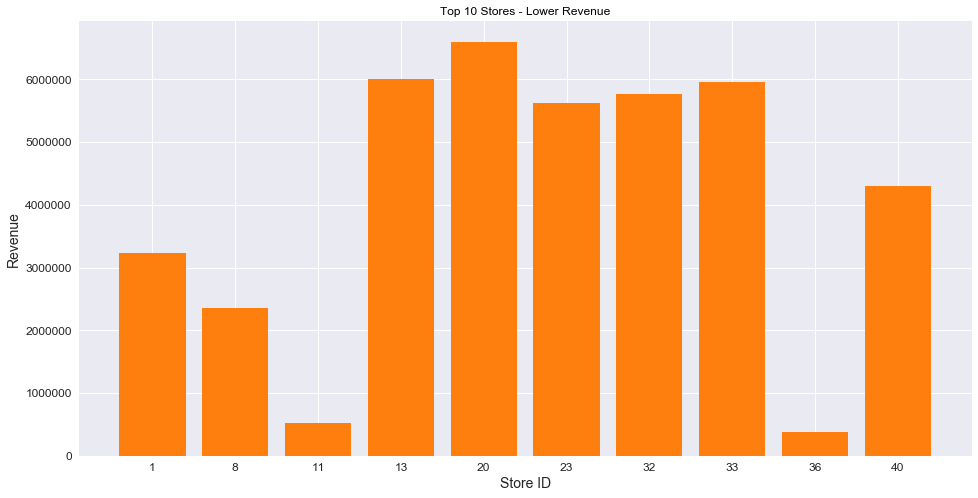

In [21]:
plt.figure(figsize=(16,8))
plt.xlabel('Store ID')
plt.ylabel('Revenue')
plt.title('Top 10 Stores - Lower Revenue')
plt.bar(stores_lower_revenue['shop_id'].astype('str'), stores_lower_revenue['total_value'], color='tab:orange')

In [22]:
sales_category = sales.groupby(['item_category_id'])['item_cnt_day'].agg(item_cnt_day='sum')
sales_category = sales_category.sort_values(by='item_cnt_day', ascending=False).astype('int')

In [23]:
category_more_sales = sales_category.iloc[0:10] # TOP 10
category_more_sales = category_more_sales.sort_values(by='item_category_id').reset_index()

category_less_sales = sales_category.iloc[-10:] # LAST 10
category_less_sales = category_less_sales.sort_values(by='item_category_id').reset_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 10 artists>

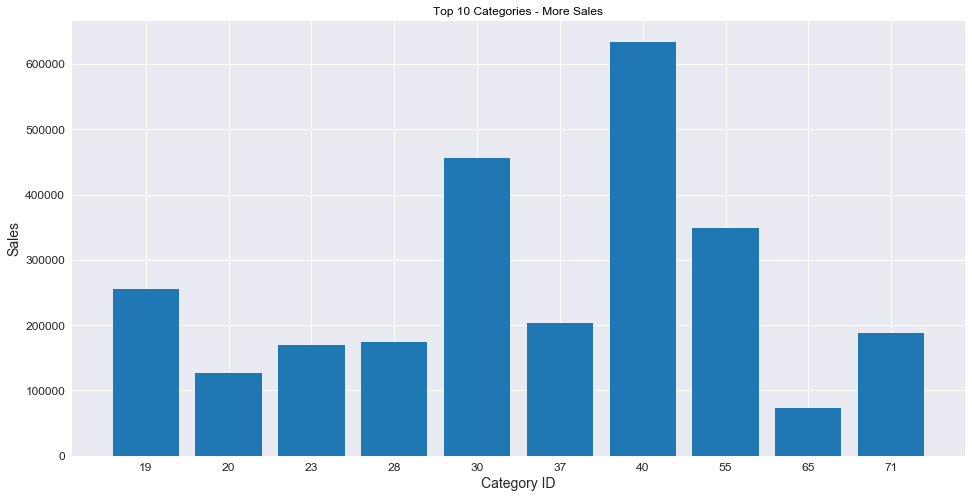

In [24]:
plt.figure(figsize=(16,8))
plt.xlabel('Category ID')
plt.ylabel('Sales')
plt.title('Top 10 Categories - More Sales')
plt.bar(category_more_sales['item_category_id'].astype('str'), category_more_sales['item_cnt_day'], color='tab:blue')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 10 artists>

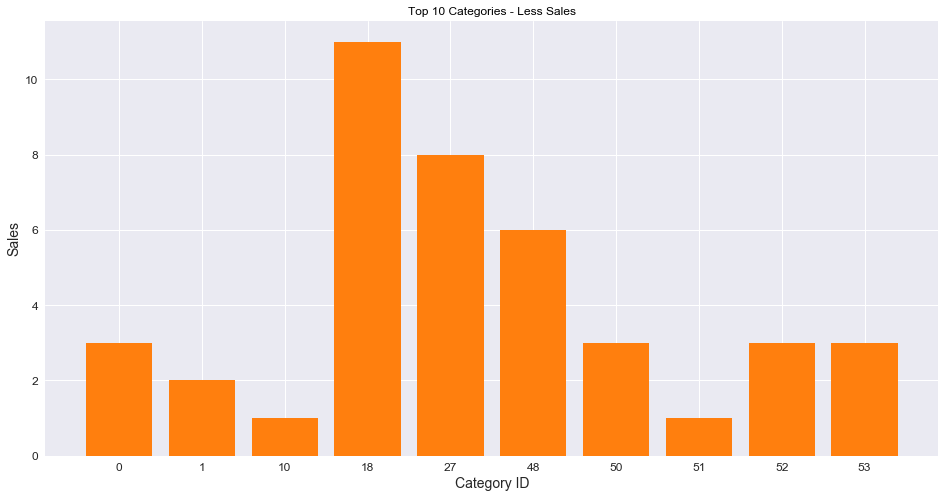

In [25]:
plt.figure(figsize=(16,8))
plt.xlabel('Category ID')
plt.ylabel('Sales')
plt.title('Top 10 Categories - Less Sales')
plt.bar(category_less_sales['item_category_id'].astype('str'), category_less_sales['item_cnt_day'], color='tab:orange')

### Machine Learning Model

#### Preprocessing

In [26]:
start_date = pd.datetime.strftime(sales['date'].min(), '%Y-%m-%d')
end_date = pd.datetime.strftime(sales['date'].max(), '%Y-%m-%d')

In [27]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
total_sales.index = pd.date_range(start=start_date, end=end_date, freq='MS')
total_sales=total_sales.reset_index()

In [28]:
total_sales.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


#### Prophet Model

In [31]:
# Prophet reqiures a pandas df at the below config: 'DS' and 'Y'.
# DS = date column; Y = numeric and represents the measurement we wish to forecast;
total_sales.columns = ['ds', 'y']

In [32]:
total_sales.head()

,ds,y
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [33]:
# Instantiate Prophet with only yearly seasonality as our data is monthly.
model = Prophet(yearly_seasonality=True)

model.fit(total_sales)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Forecasts

In [34]:
# Forecast for the next 5 months.
# MS - Month Start is the frequency.
future = model.make_future_dataframe(periods=5, freq='MS')

In [35]:
forecasts = model.predict(future)

In [38]:
forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957122,79970.082057,86224.282019
35,2015-12-01,125513.062765,122310.527366,128688.449491
36,2016-01-01,75625.688391,72268.032565,78917.226493
37,2016-02-01,40109.144285,36795.131928,43098.887022
38,2016-03-01,76664.084473,73470.432414,79942.975238


#### Visualization

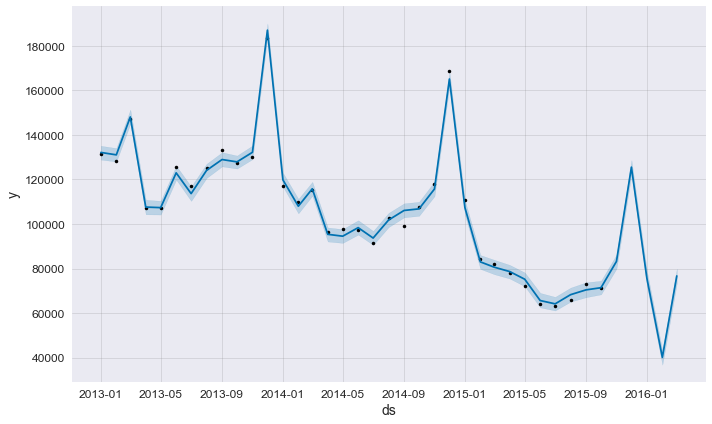

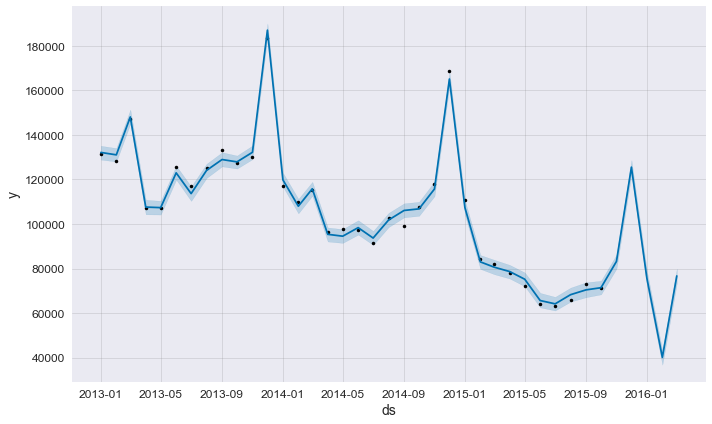

In [71]:
model.plot(forecasts)

Text(0.5, 0, 'Date')

<Figure size 1152x576 with 0 Axes>

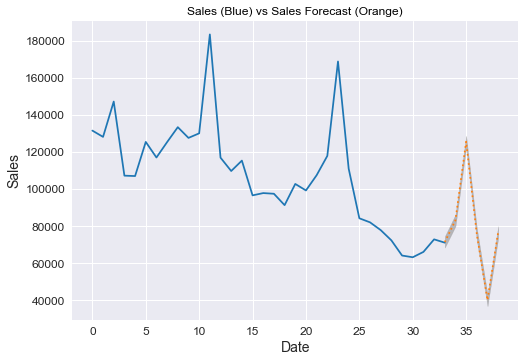

In [70]:
# print(total_sales.drop('ds', axis=1))
# print(forecasts.yhat)

# plt.figure(figsize=(16,8))
fig, ax1 = plt.subplots()
ax1.plot(total_sales.drop('ds', axis=1), color='tab:blue')
ax1.plot(forecasts[-6:].yhat, color='tab:orange', linestyle=':')
ax1.fill_between(forecasts[-6:].index, forecasts[-6:].yhat_upper, forecasts[-6:].yhat_lower, alpha=0.5, color='tab:gray')
ax1.set_title('Sales (Blue) vs Sales Forecast (Orange)')
ax1.set_ylabel('Sales')
ax1.set_xlabel('Date')

In [65]:
# forecasts.yhat_upper
